In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from pprint import pprint as pprint
from re import sub
from collections import namedtuple
from urllib2 import urlopen, Request, quote, HTTPError
from bs4 import BeautifulSoup
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from os.path import abspath, exists
from os import remove
from random import randrange
from time import sleep
from itertools import chain

%matplotlib notebook

In [2]:
# url = "https://nethouseprices.com/house-prices/london?page=1"
# html = urlopen(url)
# soup = BeautifulSoup(html, "lxml")
# TO-DO: segment HTML downloading into chunks, and see if HTML can be saved to disk, and scraped by BeautifulSoup from disk.
# Also determine how much of the data to use as a dataset, and turn all your processing code into functions, so you can do
# this processing across multiple URLs to get one dataset you can model on.
# The next step is to do k-Means Clustering and get dummies, then run Random Forest Regressor, and write RESTful API.

In [3]:
# we download our entire dataset HTMLs in chunks, and write them to disk, only opening them when we need them.
def get_url_list(generic_url_string, start_page, end_page):
    """This function simply returns a list of a generic url strings, with a page argument, from a starting page number to
    an ending page number"""
    return [generic_url_string.format(i) for i in xrange(start_page, end_page)]

def write_html_to_disk(url, generic_filepath, pageno):
    """This function takes a URL, and a generic file path, and page number, and writes the returned HTML to disk for multi-page
    websites. It is intended to be used as a way to process a list of URLs with page numbers."""
    delay = randrange(1,3)
    sleep(delay)
    f = urlopen(url)
    data = f.read()
    filename = generic_filepath.format(pageno)
    with open(filename, "w+") as html_file:
        html_file.write(data)
        print "Downloaded {} to {}".format(url, filename)

def write_multiple_html_to_disk_from_list(start, end, generic_filepath, url_list):
    """This function writes HTML objects to disk, to save on heap size"""
    url_sublist = url_list[start:end]
    [write_html_to_disk(url, generic_filepath, pgnum) for url, pgnum in zip(url_sublist, xrange(start+1,end+1))]

def read_html_from_disk(generic_filepath, pagenum):
    """This function reads a saved HTML file from disk"""
    html_filepath = abspath(generic_filepath.format(i))
    html_from_file = urlopen("file:///{}".format(html_filepath)).read()
    remove(html_filepath)
    print "Deleted {}".format(html_filepath)
    return BeautifulSoup(html_from_file, 'lxml')

In [4]:
url_list = get_url_list("https://nethouseprices.com/house-prices/london?page={}", 1, 12484)
write_multiple_html_to_disk_from_list(0, 40, "page{}_raw.html", url_list)
soup_kitchen = [read_html_from_disk("page{}_raw.html", i) for i in xrange(1,41)]

Downloaded https://nethouseprices.com/house-prices/london?page=1 to page1_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=2 to page2_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=3 to page3_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=4 to page4_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=5 to page5_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=6 to page6_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=7 to page7_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=8 to page8_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=9 to page9_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=10 to page10_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=11 to page11_raw.html
Downloaded https://nethouseprices.com/house-prices/london?page=12 to page12_raw.htm

In [5]:
def multi_page_scrape(soup_list, tag, tag_class):
    """This function is for getting tags from a collection of multiple html files as BeautifulSoup objects"""
    return list(chain.from_iterable([soup.find_all(tag, class_=tag_class) for soup in soup_list]))

def parse_date(date_string):
    """This function transforms date strings into something we can use as a datetime object"""
    ds = date_string
    dsl = ds.split(" ")
    return " ".join(["".join([char if not char.isalpha() else "" for char in dsl[0]]), " ".join(dsl[1:])])

In [6]:
# Identified from element inspections via the Chrome developer console.
# addresses = soup.find_all("strong", class_="street-details-head-row")
# prices = soup.find_all("strong", class_="street-details-price-row")
# details = soup.find_all("div", class_="street-details-row")
addresses = multi_page_scrape(soup_kitchen, "strong", "street-details-head-row")
prices = multi_page_scrape(soup_kitchen, "strong", "street-details-price-row")
details = multi_page_scrape(soup_kitchen, "div", "street-details-row")
sale_dates_rows = multi_page_scrape(soup_kitchen, "tr", "sold_price_row")

# print len(addresses), len(prices), len(details), len(sale_dates_rows)

In [7]:
sale_date_strings = [i.findChildren('td')[-1].text for i in sale_dates_rows]

cleaned_sale_date_strings = [parse_date(i) for i in sale_date_strings]
# print cleaned_sale_date_strings
sale_dates = [datetime.strptime(i, "%d %B %Y") for i in cleaned_sale_date_strings]
# sale_dates

In [8]:
# Our scraped data series are set below.
addr = [i.find("a").string.replace(u"\xa0", " ") for i in addresses]
pxs = [float(i.string.replace(u"\xa3", "").replace(u",", "")) for i in prices]
property_characteristics = [[i.strip() for i in categories.string.split(",")] for categories in details]
# for i in property_characteristics:
#     if len(i) == 2:
#         print i
#  Some of our datapoints do not have flat type, so we must adapt for this.

flat_type = [i[0] if len(i) == 3 else np.nan for i in property_characteristics]
lease_type = [i[1] if len(i) == 3 else i[0] for i in property_characteristics]
build_status = [i[2] if len(i) == 3 else i[1] for i in property_characteristics]

In [9]:
print len(flat_type), len(lease_type), len(build_status)

2000 2000 2000


In [10]:
# Defining our OpenStreetMap API data getter and transformer functions. This is a big performance bottleneck.
def get_geodata_object(openstreetmap_api_url):
    """this function takes our OpenStreetMap API URL and returns a JSON response"""
    try:
        url = openstreetmap_api_url
        sleep(1)
        req = Request(url, headers={"User-Agent": "Mozilla/5.0"})
        json_response_text = BeautifulSoup(urlopen(req), "lxml").text
        json_response = json.loads(json_response_text)
        with open("osm_responses.json", "a+") as outfile:  
            json.dump(json_response, outfile)
        return json_response
    except HTTPError as err:
        if err.code == 429:
            print "HTTP Error 429: You've been blocked for being naughty."
            json_response = json.loads("[]")
            with open('osm_responses.json', 'a+') as outfile:  
                json.dump(json_response, outfile)
            return []
        else:
            print "HTTP Error {}: Look it up.".format(err.code)
            json_response = json.loads("[]")
            with open("osm_responses.json", "a+") as outfile:  
                json.dump(json_response, outfile)
            return []

def convert_json_to_named_tuple(json_):
    """This function is solely for our convenience when referencing JSON response attributes in dataset creation"""
    return json.loads(json_, object_hook=lambda dict_: namedtuple('X', dict_.keys())(*dict_.values()))

def clean_json(json_string):
    result = json.dumps(json_string)
    result = result.replace("class", "category")
    result = result.replace("type", "subcategory")
    result = result.replace("osm_subcategory", "osm_type")
    return result

In [42]:
not exists("osm_responses.json")

False

In [11]:


# This step can result in a temporary blacklist if too many requests are made in a short period of time.
# We will segment our request into chunks.

# json_search_results_1 = [get_geodata_object(url) for url in geodata_urls[0:99]]


# def get_list_of_sublists(list_, start_index, num_items, chunk_size):
#     """This function takes a list, and returns a list of sublists each of the chunk size requested"""
#     list_of_sublists = [geodata_urls[i:i+chunk_size] for i in xrange(start_index, num_items, chunk_size)]
#     return list_of_sublists

# def get_osm_json_response(sublist):
#     """This function gets a response for each OSM API URL in our sublist of URLs, with a sleep period for responsible scraping"""
#     randrange(2,30)
#     osm_json_response_list = [get_geodata_object(url) for url in sublist]
#     return osm_json_response_list

# geodata_sublists = get_list_of_sublists(geodata_urls, 0, len(geodata_urls), 100)

if not exists("osm_responses.json"):
    geodata_urls = ["https://nominatim.openstreetmap.org/search?q=\"{}\"&format=json".format(i.replace(" ", "%20")) for i in addr]
    json_search_results = [get_geodata_object(url) for url in geodata_urls]
    top_search_results = [result if len(result) == 0 else result[0] for result in json_search_results]
else:
    # Do nothing.

# print top_search_results

In [12]:
# We now convert these top search results back to JSON to make named tuples for ease of referencing in dataseries creation.
# top_search_results_as_strings = ['[{}]'.format(str(i)) if type(i) == dict else '{}'.format(i) for i in top_search_results]
    
# top_search_results_as_json = [json.dumps(i).replace("class", "category").replace("type", "subcategory").replace("osm_subcategory", "osm_type") for i in top_search_results]
top_search_results_as_json = [clean_json(i) for i in top_search_results]
geodata_json = [convert_json_to_named_tuple(result) for result in top_search_results_as_json]

In [13]:
def load_geodata_attributes(geodata_obj):
    try:
        return (
                geodata_obj.category,
                geodata_obj.subcategory,
                float(geodata_obj.importance),
                float(geodata_obj.lon),
                float(geodata_obj.lat))
    except AttributeError: # this handles the case where our JSON loader did not find a JSON response from the API URL.
        return (np.nan, np.nan, np.nan, np.nan, np.nan)

#TO-DO: add data parsed from display_name about borough as alternative to k Mean Clustering, to data frame.
# json_search_results = [get_geodata_object(url) for url in geodata_urls]
geodata = [load_geodata_attributes(result_named_tuple) for result_named_tuple in geodata_json]

category = [i[0] for i in geodata]
subcategory = [i[1] for i in geodata]
importance = [i[2] for i in geodata]
longitude = [i[3] for i in geodata]
latitude = [i[4] for i in geodata]

In [14]:
# We construct our dataset.
variables = [addr, pxs, sale_dates, flat_type, lease_type, build_status, category, subcategory, importance, longitude, latitude]
series_names = ["addresses",
                "prices",
                "sale_dates",
                "flat_type",
                "lease_type",
                "build_status",
                "category",
                "subcategory",
                "importance",
                "longitude",
                "latitude"]

# Check all series are the same length.
if len(pxs) == sum([len(dataseries) for dataseries in variables])/len(variables):
    # Setup dictionary for dataframe.
    dataset = {series_name : series for series_name, series in zip(series_names, variables)} 

In [43]:
# Beware some erroneous lon-lat data due to multiple search results and improper parsing of JSON response.
# NB: ignore the above, this was fixed. Now have to find a way of removing bad search data, say data 1SD away from mean lat lon.

dataset_frame = pd.DataFrame(dataset)
dataset_frame.head()

# We add a new parameter, which we will use to exclude anomalous lat lon coordinates from bad Open Street Map API data.
    
dataset_frame["latitude_z_score"] = (dataset_frame.latitude - dataset_frame.latitude.mean()) / dataset_frame.latitude.std()
dataset_frame["longitude_z_score"] = (dataset_frame.longitude - dataset_frame.longitude.mean()) / dataset_frame.longitude.std()

# We create new columns which introduce NaN data where the lat lon absolute Z scores exceed 3, indicating likely bad data.
# By bad data, we mean assuming a normal distribution, the lat lon coordinates are statistically significantly different
# from the average coordinates of all other datapoints. Given all the houses should be in London, this is a good filter.

dataset_frame["lat_z_score_mask"] = dataset_frame.latitude_z_score.where(dataset_frame.latitude_z_score.abs() < 3)
dataset_frame["lon_z_score_mask"] = dataset_frame.longitude_z_score.where(dataset_frame.longitude_z_score.abs() < 3)
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,subcategory,latitude_z_score,longitude_z_score,lat_z_score_mask,lon_z_score_mask
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,NaN,NaN,NaN,NaN,NaN
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,NaN,NaN,NaN,NaN,NaN
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,secondary,0.124240,0.149754,0.124240,0.149754
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,residential,0.125155,0.149267,0.125155,0.149267
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,residential,0.101319,0.138506,0.101319,0.138506


In [45]:
dataset_frame.describe()

,importance,latitude,longitude,prices,latitude_z_score,longitude_z_score,lat_z_score_mask,lon_z_score_mask
count,1227.000000,1227.000000,1227.000000,2.000000e+03,1.227000e+03,1.227000e+03,1222.000000,1197.000000
mean,0.554560,51.145374,-1.764716,9.997376e+05,-7.475083e-15,1.790201e-16,0.047107,0.139436
std,0.083702,3.288205,11.940323,4.829894e+06,1.000000e+00,1.000000e+00,0.433211,0.074426
min,0.201000,-32.996111,-83.457167,9.980000e+02,-2.558888e+01,-6.841729e+00,-2.992539,-0.861054
25%,0.510000,51.456565,-0.195780,3.827500e+05,9.463862e-02,1.313981e-01,0.094659,0.131712
50%,0.521000,51.499684,-0.121608,5.250000e+05,1.077516e-01,1.376100e-01,0.107839,0.138061
75%,0.610000,51.557139,-0.038910,8.100000e+05,1.252246e-01,1.445359e-01,0.125229,0.144671
max,0.975490,53.806796,122.423345,1.750000e+08,8.093845e-01,1.040073e+01,0.809384,2.486974


In [16]:
# We will also create dummy variables for all our non-numerical dataseries.
build_status_dummies = pd.get_dummies(dataset_frame.build_status)
flat_type_dummies = pd.get_dummies(dataset_frame.flat_type)
lease_type_dummies = pd.get_dummies(dataset_frame.lease_type)
category_dummies = pd.get_dummies(dataset_frame.category)
subcategory_dummies = pd.get_dummies(dataset_frame.subcategory)


dataframes_set = [dataset_frame, build_status_dummies, flat_type_dummies, lease_type_dummies, category_dummies, subcategory_dummies]
# for dataframe in dataframes_set:
#     dataframe.reset_index(drop=True)
    
dataset_frame = pd.concat(dataframes_set, axis=1)
# dataset_frame = pd.concat([dataset_frame, pd.get_dummies(dataset_frame.lease_type)], axis=1)
dataset_frame.head()

,addresses,build_status,category,flat_type,importance,latitude,lease_type,longitude,prices,sale_dates,...,retail,secondary,service,suburb,tertiary,town,trunk,uncategoryified,vacant,yes
0,"Flat 14 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,517275.0,2018-09-26,...,0,0,0,0,0,0,0,0,0,0
1,"Flat 26 Buchanan House, 7 Troubridge Square, L...",Newbuild,NaN,Flat,NaN,NaN,Leasehold,NaN,527175.0,2018-09-26,...,0,0,0,0,0,0,0,0,0,0
2,"91 Dames Road, London, E7 0DW",Non-Newbuild,highway,Terraced,0.61,51.553902,Freehold,0.023391,420000.0,2018-09-25,...,0,1,0,0,0,0,0,0,0,0
3,"82 Ramsay Road, London, E7 9EW",Non-Newbuild,highway,Terraced,0.51,51.556909,Freehold,0.017585,420000.0,2018-09-25,...,0,0,0,0,0,0,0,0,0,0
4,"21 Mandela Street, London, SW9 6EL",Non-Newbuild,highway,Terraced,0.52,51.478533,Freehold,-0.110912,560000.0,2018-09-25,...,0,0,0,0,0,0,0,0,0,0


In [19]:
dataset_frame = dataset_frame.dropna()

In [20]:
cols_to_drop = ['build_status',
                'flat_type',
                'lease_type',
                'category',
                'subcategory',
                'latitude_z_score',
                'longitude_z_score',
                'lat_z_score_mask',
                'lon_z_score_mask']
final_dataset_frame = dataset_frame.drop(cols_to_drop, axis=1)
final_dataset_frame = final_dataset_frame.reset_index(drop=True)
final_dataset_frame.head()

,addresses,importance,latitude,longitude,prices,sale_dates,Newbuild,Non-Newbuild,Detached,Flat,...,retail,secondary,service,suburb,tertiary,town,trunk,uncategoryified,vacant,yes
0,"91 Dames Road, London, E7 0DW",0.61,51.553902,0.023391,420000.0,2018-09-25,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,"82 Ramsay Road, London, E7 9EW",0.51,51.556909,0.017585,420000.0,2018-09-25,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"21 Mandela Street, London, SW9 6EL",0.52,51.478533,-0.110912,560000.0,2018-09-25,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"115 Murray Road, London, W5 4DB",0.51,51.493612,-0.313211,495000.0,2018-09-24,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"55 Briar Avenue, London, SW16 3AB",0.61,51.417612,-0.119799,535000.0,2018-09-24,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
# We will save our dataset frame just in case, as a csv and json document.
final_dataset_frame.to_csv("final_dataset_frame.csv")
final_dataset_frame.to_json("final_dataset_frame.json")

In [23]:
# We will now plot our latitude and longitude coordinates to get a sense of how many clusters we may have geographically.
fdf = final_dataset_frame

x = fdf.longitude
y = fdf.latitude
z = fdf.prices

<IPython.core.display.Javascript object>


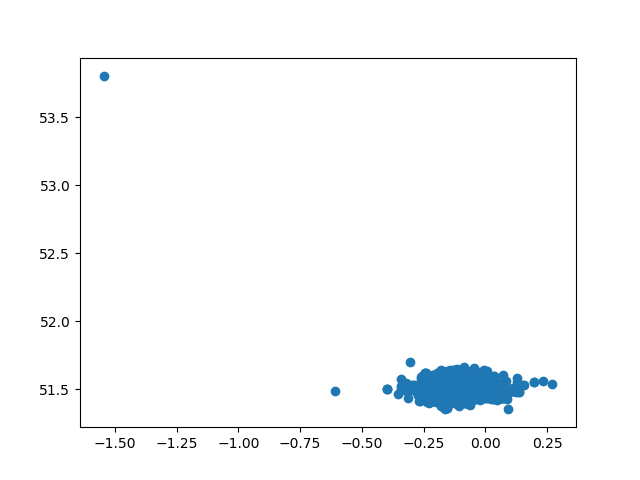

In [24]:
fig0 = plt.figure()
scat = plt.scatter(x, y)
#TO-DO: get rid of anomalous data points.

<IPython.core.display.Javascript object>


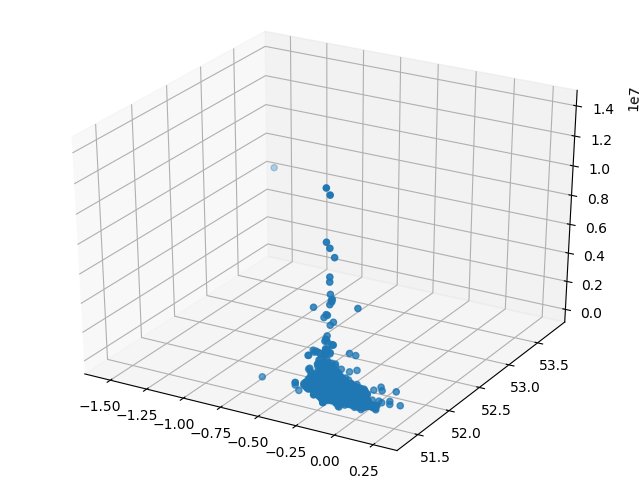

In [25]:
# We will also look at a 3D scatter plot to get an idea of where prices might be influencing clustering.
fig1 = plt.figure()
ax = Axes3D(fig1)

ax.scatter(x, y, z)

In [26]:
# We will check to see if we have any non-numerical data left before we run K-Means Clustering.
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 45 columns):
addresses            1119 non-null object
importance           1119 non-null float64
latitude             1119 non-null float64
longitude            1119 non-null float64
prices               1119 non-null float64
sale_dates           1119 non-null datetime64[ns]
Newbuild             1119 non-null uint8
Non-Newbuild         1119 non-null uint8
Detached             1119 non-null uint8
Flat                 1119 non-null uint8
Semi Detached        1119 non-null uint8
Terraced             1119 non-null uint8
Freehold             1119 non-null uint8
Leasehold            1119 non-null uint8
amenity              1119 non-null uint8
building             1119 non-null uint8
highway              1119 non-null uint8
landuse              1119 non-null uint8
place                1119 non-null uint8
shop                 1119 non-null uint8
cafe                 1119 non-null uint8
city          

In [27]:
# It looks like we forgot to get rid of the addresses, so we will do that now.
fdf = fdf.drop(['addresses'], axis=1)
fdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1119 entries, 0 to 1118
Data columns (total 44 columns):
importance           1119 non-null float64
latitude             1119 non-null float64
longitude            1119 non-null float64
prices               1119 non-null float64
sale_dates           1119 non-null datetime64[ns]
Newbuild             1119 non-null uint8
Non-Newbuild         1119 non-null uint8
Detached             1119 non-null uint8
Flat                 1119 non-null uint8
Semi Detached        1119 non-null uint8
Terraced             1119 non-null uint8
Freehold             1119 non-null uint8
Leasehold            1119 non-null uint8
amenity              1119 non-null uint8
building             1119 non-null uint8
highway              1119 non-null uint8
landuse              1119 non-null uint8
place                1119 non-null uint8
shop                 1119 non-null uint8
cafe                 1119 non-null uint8
city                 1119 non-null uint8
convenience    

In [28]:

# kmm_columns_to_remove = 

kmm_X = pd.DataFrame([fdf.latitude, fdf.longitude]).T
# kmm_X
# from sklearn.model_selection import train_test_split
# train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

In [29]:
from sklearn.cluster import KMeans

In [30]:
num_clusters = 8
kmeans = KMeans(n_clusters=8, max_iter=6000, algorithm = 'auto')
kmm = kmeans.fit(kmm_X)
id_label = kmm.labels_

<IPython.core.display.Javascript object>


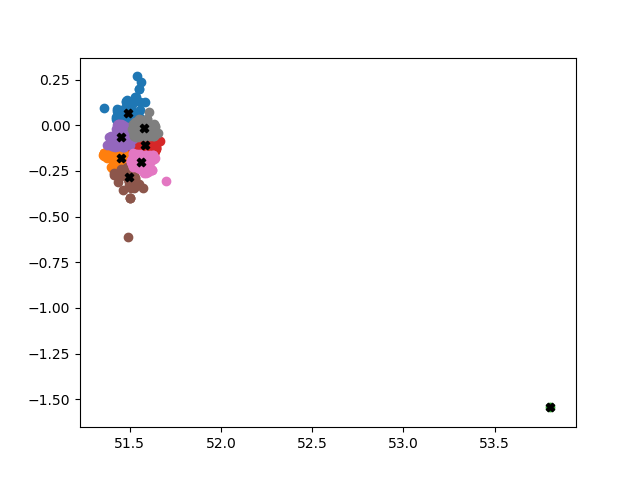

In [31]:
# We will now plot our clusters to see if the labels look correct. We also plot our cluster centres.
fig2 = plt.figure()
for i in xrange(num_clusters):
    cluster = np.where(id_label == i)[0]
    plt.scatter(kmm_X.latitude[cluster].values, kmm_X.longitude[cluster].values)
plt.scatter(kmm.cluster_centers_[:,0], kmm.cluster_centers_[:,1], c="black", marker="X")

In [33]:
# We will now add our cluster labels back to our orginal final dataset frame, and derive dummies.
kmm_label_dummies = subcategory_dummies = pd.get_dummies(kmm.labels_)
# fdf = pd.concat([kmm_label_dummies], axis=1)
# fdf

In [34]:
fdf.describe()

,importance,latitude,longitude,prices,Newbuild,Non-Newbuild,Detached,Flat,Semi Detached,Terraced,...,retail,secondary,service,suburb,tertiary,town,trunk,uncategoryified,vacant,yes
count,1119.000000,1119.000000,1119.000000,1.119000e+03,1119.0,1119.0,1119.000000,1119.000000,1119.000000,1119.000000,...,1119.0,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.000000,1119.0,1119.000000
mean,0.558655,51.511626,-0.111768,9.008423e+05,0.0,1.0,0.043789,0.329759,0.150134,0.476318,...,0.0,0.021448,0.007149,0.002681,0.058088,0.000894,0.013405,0.014298,0.0,0.082216
std,0.078441,0.094368,0.115939,1.145037e+06,0.0,0.0,0.204717,0.470336,0.357362,0.499662,...,0.0,0.144936,0.084288,0.051732,0.234014,0.029894,0.115052,0.118771,0.0,0.274817
min,0.221000,51.352929,-1.544491,1.000000e+05,0.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.510000,51.459233,-0.190963,4.250000e+05,0.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.521000,51.501357,-0.113356,5.950000e+05,0.0,1.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,0.610000,51.558722,-0.035202,9.300000e+05,0.0,1.0,0.000000,1.000000,0.000000,1.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
max,0.975490,53.806796,0.269938,1.400000e+07,0.0,1.0,1.000000,1.000000,1.000000,1.000000,...,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000
